In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate
from corner import corner
import GPy
import sys
from time import time

sys.path.append('../')
import delight
from delight.utils import approx_DL
from delight.photoz_gp import PhotozGP
from delight.photoz_kernels import Photoz_mean_function, Photoz_kernel

In [3]:
max_redshift = 2.0
survey = 'DES'
ab_filters = np.array(['g', 'r', 'i', 'z', 'Y'])
numBands = len(ab_filters)
amp_arr = np.genfromtxt('./data/'+survey+'_filter_gaussian_coefficients_amp_'+''.join(ab_filters)+'.txt')
mu_arr = np.genfromtxt('./data/'+survey+'_filter_gaussian_coefficients_mu_'+''.join(ab_filters)+'.txt')
sig_arr = np.genfromtxt('./data/'+survey+'_filter_gaussian_coefficients_sig_'+''.join(ab_filters)+'.txt')
nb, numCoefs = mu_arr.shape
                
f_mod = np.load('./data/CWW_redshiftgrid_zmax'+str(max_redshift)+'_'+survey+'_'+''.join(ab_filters)+'.npy')
f_mod2 = np.load('./data/CWW_redshiftgrid_zmax'+str(max_redshift)+'_'+survey+'_'+''.join(ab_filters)+'_nolines.npy')

f_mod3 = np.zeros_like(f_mod)
nz, nt, nf = f_mod.shape
redshiftGrid = np.linspace(0, max_redshift, num=nz)
ts = np.array([8.33e-02, 2.13e-01, 3.49e-01, 4.47e-01, 3.77e-01, 5.22e-01, 7.10e-01, 1.00e+00])
alpha = 5.86e-04
beta = 6.86e-01

oneplusz = 1. + redshiftGrid
norms = np.sqrt(2*np.pi) * np.sum(amp_arr * sig_arr, axis=1)
DL = approx_DL()
for it in range(nt):
    for jf in range(nf):
        for i in range(numCoefs):
            amp, mu, sig = amp_arr[jf, i], mu_arr[jf, i], sig_arr[jf, i]
            lambdaMin = mu - 5*sig
            lambdaMax = mu + 5*sig
            xf = np.linspace(lambdaMin, lambdaMax, num=200)
            yf = amp * np.exp(-0.5*((xf-mu)/sig)**2)
            for iz, z in enumerate(redshiftGrid):
                sed = np.exp(-alpha*(ts[it] - beta)*(xf/oneplusz[iz] - 4.5e3))
                f_mod3[iz,it,jf] += np.trapz(sed*yf, x=xf) / norms[jf] #* oneplusz[iz]**2.


f_mod_interps = np.zeros((nt, nf), dtype=object)
f_mod_interps2 = np.zeros((nt, nf), dtype=object)
f_mod_interps3 = np.zeros((nt, nf), dtype=object)
for jf in range(nf):    
    for it in range(nt):
        f_mod[:,it,jf] = oneplusz / DL(redshiftGrid)**2 / (4*np.pi) * f_mod[:,it,jf] 
        f_mod2[:,it,jf] = oneplusz / DL(redshiftGrid)**2 / (4*np.pi) * f_mod2[:,it,jf]  
        f_mod3[:,it,jf] = oneplusz / DL(redshiftGrid)**2 / (4*np.pi) * f_mod3[:,it,jf]  
        
for jf in range(nf):                            
    for it in range(nt):
        f_mod_interps[it, jf] = scipy.interpolate.interp1d(redshiftGrid, f_mod[:,it,jf], kind='cubic')
        f_mod_interps2[it, jf] = scipy.interpolate.interp1d(redshiftGrid, f_mod2[:,it,jf], kind='cubic')
        f_mod_interps3[it, jf] = scipy.interpolate.interp1d(redshiftGrid, f_mod3[:,it,jf], kind='cubic')
        
lines_mu = np.array([ 6500, 5002.26, 3732.22, 1392.07, 1542.91, 2009.82, 2384.11, 2795.42, 
                     3174.70, 4858.05, 5401.32, 6292.06, 6556.74, 6719.12, 8775.69, 
                     3253.81, 3372.75, 3528.47, 3870.62, 4104.03, 4343.24, 5308.43, 
                     6853.21, 7027.87, 7134.49, 7227.85, 9065.54, 9230.14, 9527.33, 
                     9603.17, 1213.04, 3835.44, 3969.87 ])
lines_sig = np.array([ 20.0, 34.10, 23.11, 6.41, 5.58, 22.81, 2.63, 11.14, 3.90, 3.68, 
                      11.83, 3.18, 4.39, 10.70, 6.77, 5.33, 2.14, 4.74, 9.18, 
                      7.03, 8.57, 4.43, 2.49, 11.83, 3.84, 3.13, 4.99, 4.52, 
                      5.01, 5.04, 8.20, 2.46, 2.93 ])
print lines_mu.size, lines_sig.size

33 33


In [64]:
numObjectsPerType = 10
bandsUsed = np.arange(5) # np.array([0, 2]) #
numBandsUsed = len(bandsUsed)
typesUsed = np.arange(nt) # np.array([0, 7]) #
numTypesUsed = len(typesUsed)
numpoints = numObjectsPerType*typesUsed.size
tmax = float(nt - 1)
if numObjectsPerType == 1:
    redshifts = 2*np.ones((typesUsed.size,))
else:
    if numObjectsPerType < 10:
        redshifts = np.linspace(0.1, max_redshift, num=numObjectsPerType)
    else:
        redshifts = np.random.uniform(low=0, high=max_redshift, size=numpoints)
redshifts = np.outer(redshifts, np.ones(numTypesUsed)).T.flatten()
types = np.outer(np.ones(numObjectsPerType), typesUsed).T.flatten()
types /= tmax
typesint = (types*tmax).astype(int)
luminosities = np.random.uniform(low=0, high=2, size=numpoints)
#luminosities = 1.0 + 0*types

nd = numpoints
X = np.zeros((nd, 3))
Ytruth = np.zeros((nd, numBandsUsed))
Yvar = np.zeros((nd, numBandsUsed))
Ystd = np.zeros((nd, numBandsUsed))
Y = np.zeros((nd, numBandsUsed))
off = -1
for o in range(numObjectsPerType*numTypesUsed):
    off += 1
    X[off, 0] = redshifts[o]
    X[off, 1] = luminosities[o]
    X[off, 2] = ts[typesint[o]]  
    for ib, b in enumerate(bandsUsed):
        Ytruth[off, ib] = luminosities[o] * f_mod_interps[typesint[o], b](redshifts[o])
        Ystd[off, ib] = 0.2 * Ytruth[off, ib]
        Yvar[off, ib] = (Ystd[off, ib])**2
        Y[off, ib] = Ytruth[off, ib] + Ystd[off, ib] * np.random.randn()
print 'Total number of data points:', nd*numBandsUsed

Total number of data points: 400


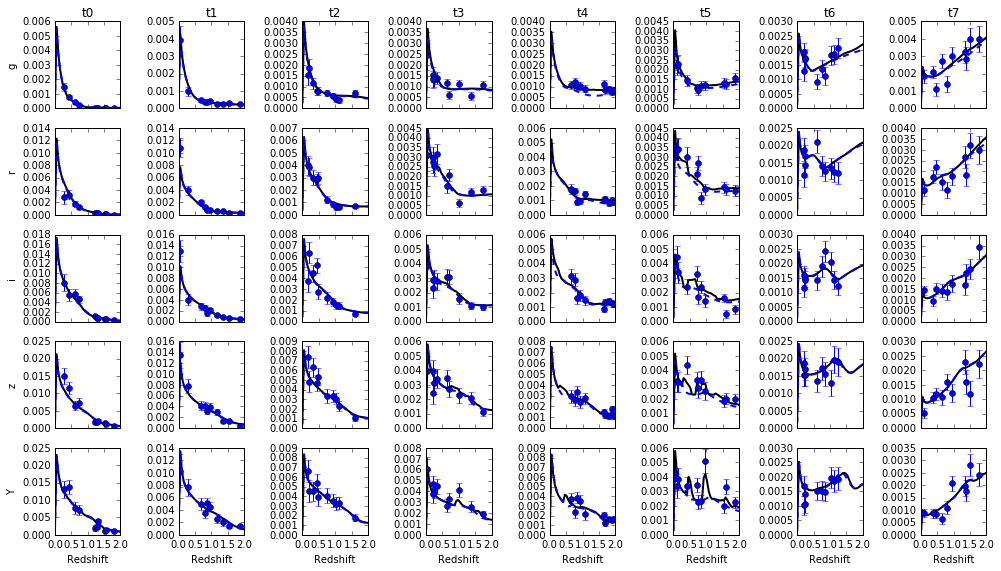

In [7]:
fig, axs = plt.subplots(nf, nt, figsize=(14, 8), sharex=True, sharey=False)
for bi in range(nf):
    for t in range(nt):
        axs[bi,t].plot(redshiftGrid, f_mod[:,t,bi], ls='solid', c='k', lw=2)
        axs[bi,t].plot(redshiftGrid, f_mod2[:,t,bi], ls='dashed', c='b', lw=2)
        #axs[bi,t].plot(redshiftGrid, f_mod3[:,t,bi], ls='dashed', c='r', lw=2)
        if t == 0:
            axs[bi,t].set_ylabel(ab_filters[bi])
        if bi == numBands - 1:
            axs[bi,t].set_xlabel('Redshift')
        if bi == 0:
            axs[bi,t].set_title('t'+str(t)) # template_names[t])

for it, t in enumerate(typesUsed):
    ind = (typesint == t) 
    for ib, b in enumerate(bandsUsed):
        axs[b,t].errorbar(X[ind,0], Y[ind,ib]/luminosities[ind], 
                          yerr=Ystd[ind,ib]/luminosities[ind], fmt='o') 
        
fig.tight_layout()

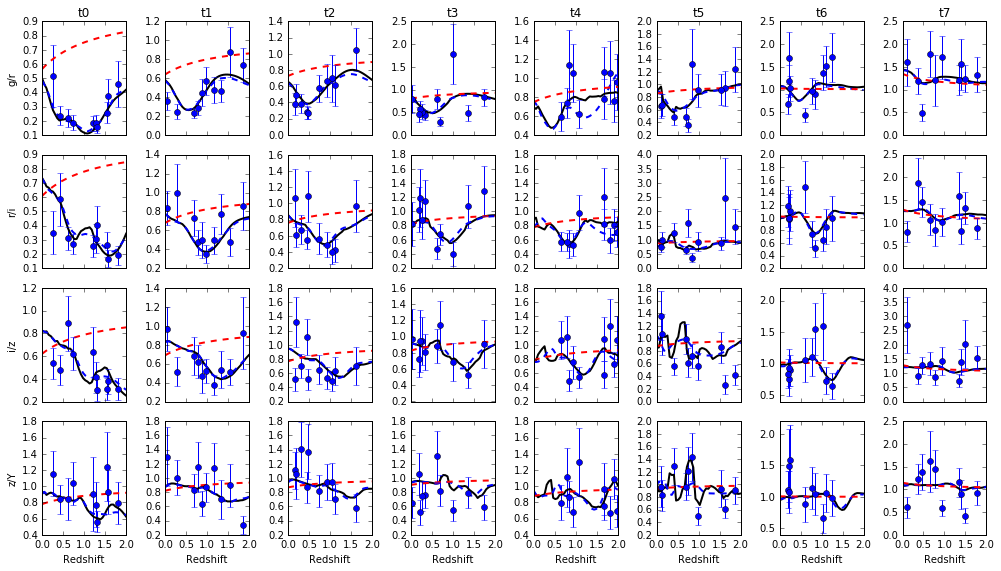

In [8]:
fig, axs = plt.subplots(nf-1, nt, figsize=(14, 8), sharex=True, sharey=False)
for bi in range(nf-1):
    for t in range(nt):
        axs[bi,t].plot(redshiftGrid, f_mod[:,t,bi]/f_mod[:,t,bi+1], ls='solid', c='k', lw=2)
        axs[bi,t].plot(redshiftGrid, f_mod2[:,t,bi]/f_mod2[:,t,bi+1], ls='dashed', c='b', lw=2)
        axs[bi,t].plot(redshiftGrid, f_mod3[:,t,bi]/f_mod3[:,t,bi+1], ls='dashed', c='r', lw=2)
        if t == 0:
            axs[bi,t].set_ylabel(ab_filters[bi]+'/'+ab_filters[bi+1])
        if bi == numBands - 2:
            axs[bi,t].set_xlabel('Redshift')
        if bi == 0:
            axs[bi,t].set_title('t'+str(t)) # template_names[t])


for ib in range(nf-1):
    v_dat = Y[:,ib] / Y[:,ib+1]
    var = v_dat**2 * Yvar[:,ib]/Y[:,ib]**2 + Yvar[:,ib+1]/Y[:,ib+1]**2)
    for it, t in enumerate(typesUsed):
        ind = (typesint == t) 
        axs[ib,t].errorbar(X[ind,0], v_dat[ind], yerr=np.sqrt(var[ind]), fmt='o') 
        
fig.tight_layout()

In [9]:
redshiftGridInterp = np.linspace(0, 2, num=40)
typeBinsize = 0.1
types_inducing = 1*ts # np.arange(0, 1.01, typeBinsize)
print types_inducing
print ts
xv, yv, zv = np.meshgrid(bandsUsed, redshiftGridInterp, types_inducing, sparse=False, indexing='xy')
nInducing = xv.size
X_inducing = np.ones((nInducing, 4))
X_inducing[:, 0] = xv.flatten()
X_inducing[:, 1] = yv.flatten()
X_inducing[:, 3] = zv.flatten()
print X_inducing.shape

[ 0.0833  0.213   0.349   0.447   0.377   0.522   0.71    1.    ]
[ 0.0833  0.213   0.349   0.447   0.377   0.522   0.71    1.    ]
(1600, 4)


In [10]:
alpha_C = 5e2
alpha_L = 1e1
alpha_T = typeBinsize * 2
var_C = 0.5
var_L = 1e4
extranoise = 1e-9

alpha = 5.86e-04
beta = 6.86e-01
lines_mu = np.array([ 6500, 5002.26, 3732.22])
lines_sig = np.array([ 20.0, 34.10, 23.11])


redshifts, luminosities, types = np.split(X, 3, axis=1)
unfixed_indices = np.arange(redshifts.shape[0])

types[types <= 0] = 0.01
types[types >= 1] = 0.99
gp = PhotozGP(
    redshifts, luminosities, types, unfixed_indices,
    Y, Yvar, extranoise, bandsUsed,
    amp_arr, mu_arr, sig_arr,
    lines_mu, lines_sig,
    alpha, beta, var_C, var_L,
    alpha_C, alpha_L, alpha_T,
    prior_z_t=None,
    prior_ell_t=None,
    prior_t=None,
    X_inducing=X_inducing,
    redshiftGrid=redshiftGridInterp,
    use_interpolators=True
    )

gp.extranoise.constrain_bounded(0, 1e-6)
gp.kern.var_C.constrain_bounded(0.2, 2.5)#constrain_positive()
gp.kern.var_L.constrain_bounded(1e6, 2e6)#constrain_positive()
gp.kern.alpha_T.constrain_bounded(0.1, 0.5)
gp.kern.alpha_C.fix()#.constrain_bounded(1e3, 1e4)
gp.kern.alpha_L.fix()#.constrain_bounded(1e1, 1e3)
gp.mean_function.alpha.fix()
gp.mean_function.beta.fix()
gp.unfixed_redshifts.fix()

gp.unfixed_types.constrain_bounded(0, 1)
gp.unfixed_luminosities.constrain_bounded(0, 30)

gp.optimize('bfgs', messages=True)
best_fit_parameters = gp.optimizer_array.copy()

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


In [63]:
f_mod = np.zeros((Y.shape[0], types_inducing.size, Y.shape[1]))
f_mod_err = np.zeros_like(f_mod)
for it, t in enumerate(types_inducing):
    for ib, jf in enumerate(bandsUsed):
        ind = np.logical_and(gp.X_inducing[:,3] == t, gp.X_inducing[:,0].astype(int) == jf)
        f_mod[:, it, ib] = np.interp(redshifts[:,0], redshiftGridInterp, gp.Y_inducing_mean[ind,0])
        f_mod_err[:, it, ib] = np.interp(redshifts[:,0], redshiftGridInterp, gp.Y_inducing_std[ind,0])

f_obs_inverrsq = np.where(Y/Ystd<1e-6, 0.0, Ystd**-2.0)
V = Y * f_obs_inverrsq
FOT = np.sum(f_mod * V[:, None, :], axis=(2))
FTT = np.sum(f_mod**2.0 * f_obs_inverrsq[:, None, :], axis=(2))
FOO = np.sum(Y**2.0 * f_obs_inverrsq[:, :], axis=(1))
chi2 = FOO[:, None] - FOT**2.0 / FTT 
like = np.exp(-0.5*chi2) / np.sqrt(FTT) # nz * nt

type_estimates = np.argmax(like, axis=1)[:, None]
luminosity_estimates = np.zeros_like(type_estimates, dtype=float)
for o, t in enumerate(type_estimates[:, 0]):
    for ib, jf in enumerate(bandsUsed):
        luminosity_estimates[o, 0] += (Y[o, ib]/f_mod[o, t, ib]) / numBandsUsed

In [ ]:
truthdict = {'photoz_mf.alpha': alpha, 'photoz_mf.beta': beta, 
             'photoz_kern.var_C': var_C, 'photoz_kern.var_L': var_L, 
             'photoz_kern.alpha_C': alpha_C, 'photoz_kern.alpha_T': alpha_T}
for i, (l, z, t) in enumerate(zip(luminosities, redshifts, types)):
    ich = str(i)
    if i > 9:
        ich += ' '
    if i > 99:
        ich += ' '
    if i > 999:
        ich += ' '
    truthdict['luminosities[['+ich+' 0]]'] = l[0]
    truthdict['redshifts[['+ich+' 0]]'] = z[0]
    truthdict['types[['+ich+' 0]]'] = t[0]

In [ ]:
fig, axs = plt.subplots(types_inducing.size, numBandsUsed, 
                        figsize=(14, 1.5*types_inducing.size), sharex=True, sharey=False)
for it, t in enumerate(types_inducing):
    for jf in bandsUsed:
        if it == 0:
            axs[it,jf].set_title(ab_filters[jf])
        if it == nt-1:
            axs[it,jf].set_xlabel('Redshift')
            axs[it,jf].set_xlim([0, max_redshift*1.1])
        if it == 0:
            axs[it,jf].set_title(ab_filters[jf])
        if jf == 0:
            axs[it,jf].set_ylabel(t) # template_names[t])
            
    for itm in range(nt):
        if ts[itm] < t + typeBinsize/2 and ts[itm] >= t - typeBinsize/2:
            for jf in bandsUsed:
                axs[it,jf].plot(redshiftGrid, f_mod[:,itm,jf], ls='solid', lw=1, c='k')
                #axs[t,jf].plot(redshiftGrid, f_mod2[:,t,jf], ls='solid', lw=2, c='b')
                #axs[t,jf].plot(redshiftGrid, f_mod3[:,t,jf], ls='solid', lw=2, c='r')
        
    thetypes = gp.types.ravel()
    for ib, jf in enumerate(bandsUsed):
        b1 = bandsUsed[ib].astype(int) 
        ind = np.logical_and(thetypes < t + typeBinsize/2, thetypes >= t - typeBinsize/2)
        l = gp.luminosities[ind,0]
        axs[it,b1].errorbar(redshifts[ind], Y[ind,ib]/l, yerr=Ystd[ind,ib]/l, fmt='o', c='gray', markersize=3)

        ind = np.logical_and(gp.X_inducing[:,3] == t, gp.X_inducing[:,0].astype(int) == jf)
        m = gp.Y_inducing_mean[ind,0][:-1]
        s = gp.Y_inducing_std[ind,0][:-1]
        axs[it,jf].plot(redshiftGridInterp[:-1], m, color='gray', alpha=0.6)
        axs[it,jf].fill_between(redshiftGridInterp[:-1], m-s, m+s, color='gray', alpha=0.2)
            
fig.tight_layout()

In [ ]:
fig, axs = plt.subplots(types_inducing.size, numBandsUsed, 
                        figsize=(14, 1.5*types_inducing.size), sharex=True, sharey=False)
for it, t in enumerate(types_inducing):
    for jf in bandsUsed:
        if it == 0:
            axs[it,jf].set_title(ab_filters[jf])
        if it == nt-1:
            axs[it,jf].set_xlabel('Redshift')
            axs[it,jf].set_xlim([0, max_redshift*1.1])
        if it == 0:
            axs[it,jf].set_title(ab_filters[jf])
        if jf == 0:
            axs[it,jf].set_ylabel(t) # template_names[t])
        
    thetypes = gp.types.ravel()
    for ib, jf in enumerate(bandsUsed):
        ind = np.logical_and(gp.X_inducing[:,3] == t, gp.X_inducing[:,0].astype(int) == jf)
        m = gp.Y_inducing_mean[ind,0][:-1]
        s = gp.Y_inducing_std[ind,0][:-1]
        intrp = scipy.interpolate.interp1d(redshiftGridInterp[:-1], m)
        axs[it,jf].plot(redshiftGridInterp[:-1], m*0, color='gray', alpha=0.6)
        axs[it,jf].fill_between(redshiftGridInterp[:-1], -s, +s, color='gray', alpha=0.2)
        b1 = bandsUsed[ib].astype(int) 
        ind = np.logical_and(thetypes < t + typeBinsize/2, thetypes >= t - typeBinsize/2)
        ind &= redshifts[:,0] < np.max(redshiftGridInterp[:-1])
        l = gp.luminosities[ind,0]
        axs[it,b1].errorbar(redshifts[ind], Y[ind,ib]/l-intrp(redshifts[ind,0]), yerr=Ystd[ind,ib]/l, fmt='o', c='gray', markersize=3)
           
fig.tight_layout()

In [ ]:
fig, axs = plt.subplots(nt, nf, figsize=(12, 14), sharex=True, sharey=False)
Xb = np.zeros((redshiftGrid.size, 4))
Xb[:, 1] = redshiftGrid
Xb[:, 2] = 1.0
for t in range(nt):
    Xb[:, 3] = t / tmax
    for jf in range(nf):
        Xb[:, 0] = jf
        axs[t,jf].plot(redshiftGrid, f_mod[:,t,jf]*0, ls='solid', lw=2, c='k')
        m, s = gp._raw_predict(Xb, full_cov=False)
        m = m.flatten()
        s = np.sqrt(s).flatten()
        axs[t,jf].plot(redshiftGrid, m-f_mod[:,t,jf], c='b')
        axs[t,jf].fill_between(redshiftGrid, m-s-f_mod[:,t,jf], m+s-f_mod[:,t,jf], color='b', alpha=0.5)
            
        if t == 0:
            axs[t,jf].set_title(ab_filters[jf])
        if t == nt-1:
            axs[t,jf].set_xlabel('Redshift')
        if jf == 0:
            axs[t,jf].set_ylabel('t'+str(t)) # template_names[t])
for it, t in enumerate(typesUsed):
    for ib, b in enumerate(bandsUsed):
        ind = (X[:,2] == t / tmax)  
        axs[t,b].errorbar(X[ind,0], Y[ind,ib]-Ytruth[ind,ib], yerr=Ystd[ind,ib], fmt='o', markersize=7)
fig.tight_layout()

In [ ]:
t1 = time()
hmc = GPy.inference.mcmc.HMC(gp, stepsize=1e-2)
hmc_samples = hmc.sample(num_samples=10) 
t2 = time()
print 'Time per HMC iteration: %.4g s' % ((t2-t1)/hmc_samples.shape[0])

In [ ]:
fig = corner(hmc_samples, labels=gp.parameter_names_flat())
fig.tight_layout()
mean_parameters = hmc_samples.mean(axis=0)
print 'mean_parameters', mean_parameters

In [ ]:
fig, axs = plt.subplots(nt, nf, figsize=(12, 14), sharex=True, sharey=False)
for t in typesUsed:
    for jf in range(nf):
        axs[t,jf].plot(redshiftGrid, f_mod[:,t,jf]*0, ls='solid', lw=2, c='k')
        if t == 0:
            axs[t,jf].set_title(ab_filters[jf])
        if t == nt-1:
            axs[t,jf].set_xlabel('Redshift')
            axs[t,jf].set_xlim([0, max_redshift*1.1])
        if jf == 0:
            axs[t,jf].set_ylabel('t'+str(t)) # template_names[t])
for it, t in enumerate(typesUsed):
    for ib, b in enumerate(bandsUsed):
        ind = (X[:,2] == t / tmax)  
        axs[t,b].errorbar(X[ind,0], Y[ind,ib]-Ytruth[ind,ib], yerr=Ystd[ind,ib], fmt='o', markersize=7)

num_samples = hmc_samples.shape[0]
fluxes = np.zeros((nt, nf, nz, num_samples))
for ip, params in enumerate(hmc_samples[:num_samples]):
    gp.set_unfixed_parameters(params)
    Xb = np.zeros((redshiftGrid.size, 4))
    Xb[:, 1] = redshiftGrid
    Xb[:, 2] = 1.0
    for t in typesUsed:
        Xb[:, 3] = t / tmax
        for jf in range(nf):
            Xb[:, 0] = jf
            fluxes[t,jf,:,ip] = gp.posterior_samples_f(Xb, size=1, full_cov=False).flatten()
            #axs[t,jf].plot(redshiftGrid, fluxes[t,jf,:,ip].flatten(), color='gray', alpha=0.5)
            
for t in typesUsed:
    Xb[:, 3] = t / tmax
    for jf in range(nf):
        Xb[:, 0] = jf
        m = fluxes[t,jf,:,:].mean(axis=1)
        s = fluxes[t,jf,:,:].std(axis=1)
        axs[t,jf].plot(redshiftGrid, m-f_mod[:,t,jf], color='gray', alpha=0.6)
        axs[t,jf].fill_between(redshiftGrid, m-s-f_mod[:,t,jf], m+s-f_mod[:,t,jf], color='gray', alpha=0.2)
        gp.set_unfixed_parameters(mean_parameters)
        m, s = gp._raw_predict(Xb, full_cov=False)
        m = m.flatten()
        s = np.sqrt(s.flatten())
        axs[t,jf].plot(redshiftGrid, m-f_mod[:,t,jf], color='b', alpha=0.5)
        axs[t,jf].fill_between(redshiftGrid, m-s-f_mod[:,t,jf], m+s-f_mod[:,t,jf], color='b', alpha=0.1)
            
fig.tight_layout()

In [ ]:
type_estimates = np.zeros_like(types)
luminosity_estimates = np.zeros_like(types)
for o in range(Y.shape[0]):
    chi2s = np.zeros((nt,))
    z = redshifts[o]
    for t in range(nt):
        for ib in range(numBandsUsed-1):
            b1 = bandsUsed[ib]
            b2 = bandsUsed[ib+1]
            v_mod = (f_mod_interps[t,b1](z) / f_mod_interps[t,b2](z))[0]
            v_dat = Y[o,ib] / Y[o,ib+1]
            var = v_dat**2 * ((Ystd[o,ib]/Y[o,ib])**2 + (Ystd[o,ib+1]/Y[o,ib+1])**2)
            #print v_mod, v_dat, var
            chi2s[t] += -0.5*((v_dat - v_mod))**2/var - np.sqrt(var)
    #print chi2s
    t = np.argmax(chi2s)
    type_estimates[o,0] = t / tmax
    
    for ib in range(numBandsUsed):
        b1 = bandsUsed[ib].astype(int)
        v_mod = f_mod_interps[t,b1](z)[0] 
        v_dat = Y[o,ib]
        luminosity_estimates[o,0] += (v_dat/v_mod) / numBandsUsed
    #print types[o,0], type_estimates[o,0]
    #print luminosities[o,0], luminosity_estimates[o,0]
type_estimates[type_estimates <= 0] = 0.001
type_estimates[type_estimates >= 1] = 0.999

In [ ]:
fig, axs = plt.subplots(2, 1)
axs[0].scatter(types, type_estimates)
axs[1].scatter(types-type_estimates, luminosities-luminosity_estimates)

In [ ]:
gp.set_types(type_estimates)
gp.set_luminosities(luminosity_estimates)

gp.luminosities.constrain_bounded(0, 10)
gp.types.constrain_bounded(0, 1)
gp.redshifts.fix()

gp.kern.var_C.fix()#.constrain_bounded(1e1, 1e4)#constrain_positive()
gp.kern.var_L.fix()#constrain_bounded(1e1, 1e4)#constrain_positive()
gp.kern.alpha_T.fix()#.constrain_bounded(0.1, 1.5)
gp.kern.alpha_C.fix()#.constrain_bounded(5e2, 2e3)
gp.kern.alpha_L.fix()#constrain_bounded(1e1, 1e2)
gp.mean_function.alpha.fix()#.constrain_bounded(1e-3, 2e-3)
gp.mean_function.beta.fix()#.constrain_bounded(1.5, 2.6)

truthdict = {'photoz_mf.alpha': alpha, 'photoz_mf.beta': beta, 
             'photoz_kern.var_C': var_C, 'photoz_kern.alpha_C': alpha_C, 'photoz_kern.alpha_T': alpha_T}
for i, (l, z, t) in enumerate(zip(luminosities, redshifts, types)):
    ich = str(i)
    if i > 9:
        ich += ' '
    truthdict['luminosities[['+ich+' 0]]'] = l[0]
    truthdict['redshifts[['+ich+' 0]]'] = z[0]
    truthdict['types[['+ich+' 0]]'] = t[0]
 
print gp
#gp.optimize('bfgs', messages=True)

In [ ]:
t1 = time()
hmc = GPy.inference.mcmc.HMC(gp, stepsize=1e-2)
hmc_samples = hmc.sample(num_samples=1000, hmc_iters=10) # TODO: add timing
t2 = time()
print 'Time per HMC iteration: %.4g s' % ((t2-t1)/hmc_samples.shape[0])

In [ ]:
np.set_printoptions(precision=2)
print np.vstack((hmc_samples.mean(axis=0)[:20], 
                 hmc_samples.std(axis=0)[:20])).T
ind = hmc_samples.std(axis=0) < 1e-12
print 'Number of parameters that didnt move:', np.sum(ind) / hmc_samples.shape[0]
print gp.parameter_names_flat()[ind]

In [ ]:
ny = 4
npar = gp.parameter_names_flat().size
nx = npar / ny + npar % ny
fig, axs = plt.subplots(nx, ny, figsize=(15, nx*1.7))
axs = axs.ravel()
for i, nm in enumerate(gp.parameter_names_flat()):
    axs[i].hist(hmc_samples[:,i], histtype='step')
    axs[i].axvline(truthdict[nm[9:]], c='k')
    axs[i].set_xlabel(nm[9:])
    if nm[9] == 't':
        axs[i].set_xlim([0, 1])
    if nm[9] == 'l':
        axs[i].set_xlim([0, 2])
fig.tight_layout()
mean_parameters = hmc_samples.mean(axis=0)

In [ ]:
fig, axs = plt.subplots(nt, nf, figsize=(12, 14), sharex=True, sharey=False)
for t in typesUsed:
    for jf in range(nf):
        axs[t,jf].plot(redshiftGrid, f_mod[:,t,jf]*0, ls='solid', lw=2, c='k')
        if t == 0:
            axs[t,jf].set_title(ab_filters[jf])
        if t == nt-1:
            axs[t,jf].set_xlabel('Redshift')
            axs[t,jf].set_xlim([0, max_redshift*1.1])
        if jf == 0:
            axs[t,jf].set_ylabel('t'+str(t)) # template_names[t])
for it, t in enumerate(typesUsed):
    for ib, b in enumerate(bandsUsed):
        ind = (X[:,2] == t / tmax)  
        axs[t,b].errorbar(X[ind,0], Y[ind,ib]-Ytruth[ind,ib], yerr=Ystd[ind,ib], fmt='o', markersize=7)

num_samples = hmc_samples.shape[0]
fluxes_mean = np.zeros((nt, nf, nz, num_samples))
fluxes_samp = np.zeros((nt, nf, nz, num_samples))
for ip, params in enumerate(hmc_samples[:num_samples]):
    gp.set_unfixed_parameters(params)
    Xb = np.zeros((redshiftGrid.size, 4))
    Xb[:, 1] = redshiftGrid
    Xb[:, 2] = 1.0
    for t in typesUsed:
        Xb[:, 3] = t / tmax
        for jf in range(nf):
            Xb[:, 0] = jf
            fluxes_samp[t,jf,:,ip] = gp.posterior_samples_f(Xb, size=1, full_cov=False).flatten()
            s , var = gp._raw_predict(Xb, full_cov=False)
            fluxes_mean[t,jf,:,ip] = s.flatten()
            
for t in typesUsed:
    Xb[:, 3] = t / tmax
    for jf in range(nf):
        Xb[:, 0] = jf
        m = fluxes_mean[t,jf,:,:].mean(axis=1)
        s = fluxes_mean[t,jf,:,:].std(axis=1)
        axs[t,jf].plot(redshiftGrid, m-f_mod[:,t,jf], color='b', alpha=0.6)
        axs[t,jf].fill_between(redshiftGrid, m-s-f_mod[:,t,jf], m+s-f_mod[:,t,jf], color='b', alpha=0.2)
        m = fluxes_samp[t,jf,:,:].mean(axis=1)
        s = fluxes_samp[t,jf,:,:].std(axis=1)
        axs[t,jf].plot(redshiftGrid, m-f_mod[:,t,jf], color='gray', alpha=0.6)
        axs[t,jf].fill_between(redshiftGrid, m-s-f_mod[:,t,jf], m+s-f_mod[:,t,jf], color='gray', alpha=0.2)
            
fig.tight_layout()